In [1]:
import os
import errno
import numpy as np 
import deepcell

In [2]:
# create folder for this set of experiments
experiment_folder = "20201206_transfer_decidua"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
npz1 = np.load(NPZ_DIR + '20200524_IF_Training_8_copy.npz')
# npz2 = np.load(NPZ_DIR + 'Eliot_20200514_256x256_stride_0.5.npz')
# npz1 = np.load(NPZ_DIR + 'cHL_256x256_stride_0.5.npz')
npz2 = np.load(NPZ_DIR + 'CyCIF_256x256_stride_0.5_copy.npz')
npz3 = np.load(NPZ_DIR + '20200518_christine_CyCIF_256_0.5.npz')
#npz2 = np.load(NPZ_DIR + '20200518_christine_CyCIF_256_0.5.npz')

In [6]:
combined_x = np.concatenate((npz1['X'], npz2['X'], npz3['X']), axis=0)
combined_y = np.concatenate((npz1['y'], npz2['y'], npz3['y']), axis=0)

#np.savez(NPZ_DIR + '20200514_IF_Training_8.npz', X=combined_x, y=combined_y)
np.savez(NPZ_DIR + '20200524_IF_Training_9.npz', X=combined_x, y=combined_y)

In [7]:
combined_x.shape

(3158, 256, 256, 2)

In [61]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200514_IF_Training_8"
npz_name = "20200521_IF_Training_256"
npz_name = "Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5"

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'].astype('float32'), train_dict['y']
X_val, y_val = val_dict['X'].astype('float32'), val_dict['y']

X.shape: (576, 256, 256, 6)
y.shape: (576, 256, 256, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


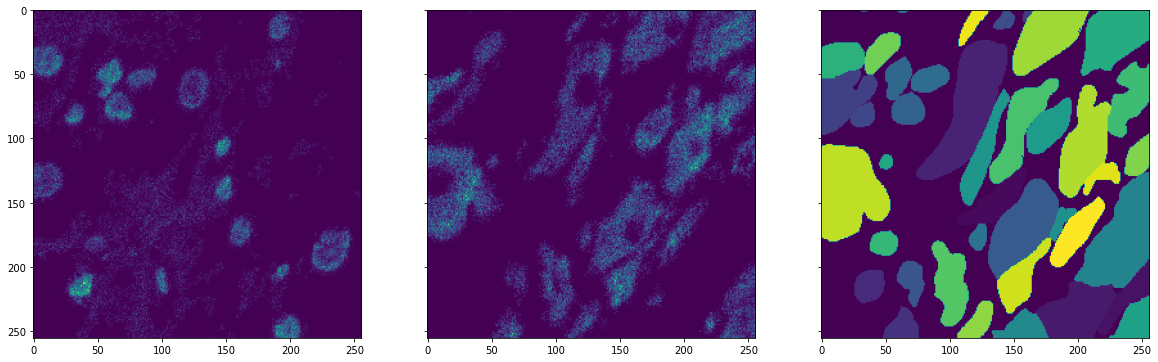

In [62]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 103
axes[0].imshow(X_train[idx,:,:,0])
axes[1].imshow(X_train[idx,:,:,1])
axes[2].imshow(y_train[idx,:,:,0])
print(np.unique(y_train[idx]))

In [63]:
from deepcell.utils import train_utils
from skimage.exposure import equalize_adapthist, rescale_intensity
import skimage

k=128
for i in range(X_train.shape[0]):
    X = X_train[i,...,0]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_train[i,...,0] = X
    
    X = X_train[i,...,1]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_train[i,...,1] = X
    

for i in range(X_val.shape[0]):
    X = X_val[i,...,0]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_val[i,...,0] = X
    
    X = X_val[i,...,1]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_val[i,...,1] = X

In [109]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

In [65]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed_original_decidua'

n_epoch = 45  # Number of training epochs
test_size = .10  # % of data saved as test

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_deep_watershed_original_decidua'

In [66]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

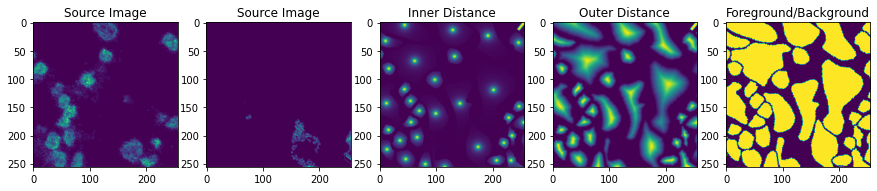

In [127]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('Source Image')

axes[1].imshow(img[:, :, 2])
axes[1].set_title('Source Image')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(pixelwise[0, ..., 1])
axes[4].set_title('Foreground/Background')

plt.show()

In [128]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [129]:
model.compile(loss=loss, optimizer=optimizer)

In [130]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/45
71/72 [============================>.] - ETA: 0s - loss: 0.1895 - semantic_0_loss: 0.0669 - semantic_1_loss: 0.1088 - semantic_2_loss: 0.0048 - semantic_3_loss: 0.0090
Epoch 00001: val_loss improved from inf to 0.29538, saving model to /data/analyses/20201206_transfer_decidua/Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_deep_watershed_original_decidua.h5
72/72 [==============================] - 260s 4s/step - loss: 0.1876 - semantic_0_loss: 0.0661 - semantic_1_loss: 0.1077 - semantic_2_loss: 0.0048 - semantic_3_loss: 0.0090 - val_loss: 0.2954 - val_semantic_0_loss: 0.0145 - val_semantic_1_loss: 0.0930 - val_semantic_2_loss: 0.0806 - val_semantic_3_loss: 0.1074
Epoch 2/45
71/72 [============================>.] - ETA: 0s - loss: 0.0529 - semantic_0_loss: 0.0095 - semantic_1_loss: 0.0325 - semantic_2_loss: 0.0035 - semantic_3_loss: 0.0073
Epoch 00002: val_loss improved from 0.29538 to 0.27225, saving model to /data/analyses/20201206_transfer_decidua/De

72/72 [==============================] - 36s 501ms/step - loss: 0.0373 - semantic_0_loss: 0.0074 - semantic_1_loss: 0.0213 - semantic_2_loss: 0.0027 - semantic_3_loss: 0.0059 - val_loss: 0.0590 - val_semantic_0_loss: 0.0104 - val_semantic_1_loss: 0.0364 - val_semantic_2_loss: 0.0042 - val_semantic_3_loss: 0.0079
Epoch 15/45
71/72 [============================>.] - ETA: 0s - loss: 0.0365 - semantic_0_loss: 0.0073 - semantic_1_loss: 0.0209 - semantic_2_loss: 0.0026 - semantic_3_loss: 0.0057
Epoch 00015: val_loss improved from 0.05902 to 0.04497, saving model to /data/analyses/20201206_transfer_decidua/Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_deep_watershed_original_decidua.h5
72/72 [==============================] - 36s 503ms/step - loss: 0.0365 - semantic_0_loss: 0.0073 - semantic_1_loss: 0.0209 - semantic_2_loss: 0.0026 - semantic_3_loss: 0.0058 - val_loss: 0.0450 - val_semantic_0_loss: 0.0085 - val_semantic_1_loss: 0.0263 - val_semantic_2_loss: 0.0034 - val_semantic_3_loss: 

Epoch 28/45
71/72 [============================>.] - ETA: 0s - loss: 0.0336 - semantic_0_loss: 0.0066 - semantic_1_loss: 0.0191 - semantic_2_loss: 0.0024 - semantic_3_loss: 0.0055
Epoch 00028: val_loss did not improve from 0.03150
72/72 [==============================] - 31s 424ms/step - loss: 0.0336 - semantic_0_loss: 0.0066 - semantic_1_loss: 0.0190 - semantic_2_loss: 0.0024 - semantic_3_loss: 0.0055 - val_loss: 0.0316 - val_semantic_0_loss: 0.0068 - val_semantic_1_loss: 0.0168 - val_semantic_2_loss: 0.0025 - val_semantic_3_loss: 0.0056
Epoch 29/45
71/72 [============================>.] - ETA: 0s - loss: 0.0334 - semantic_0_loss: 0.0066 - semantic_1_loss: 0.0189 - semantic_2_loss: 0.0024 - semantic_3_loss: 0.0055
Epoch 00029: val_loss improved from 0.03150 to 0.03103, saving model to /data/analyses/20201206_transfer_decidua/Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_deep_watershed_original_decidua.h5
72/72 [==============================] - 37s 510ms/step - loss: 0.0335 - sem

Epoch 41/45
71/72 [============================>.] - ETA: 0s - loss: 0.0325 - semantic_0_loss: 0.0064 - semantic_1_loss: 0.0183 - semantic_2_loss: 0.0024 - semantic_3_loss: 0.0054
Epoch 00041: val_loss improved from 0.03007 to 0.03001, saving model to /data/analyses/20201206_transfer_decidua/Decidua_Shirley_Relabel_Blanked_256x256_stride_0.5_deep_watershed_original_decidua.h5
72/72 [==============================] - 36s 502ms/step - loss: 0.0324 - semantic_0_loss: 0.0064 - semantic_1_loss: 0.0183 - semantic_2_loss: 0.0024 - semantic_3_loss: 0.0054 - val_loss: 0.0300 - val_semantic_0_loss: 0.0066 - val_semantic_1_loss: 0.0161 - val_semantic_2_loss: 0.0022 - val_semantic_3_loss: 0.0052
Epoch 42/45
71/72 [============================>.] - ETA: 0s - loss: 0.0322 - semantic_0_loss: 0.0064 - semantic_1_loss: 0.0181 - semantic_2_loss: 0.0023 - semantic_3_loss: 0.0053
Epoch 00042: val_loss improved from 0.03001 to 0.02982, saving model to /data/analyses/20201206_transfer_decidua/Decidua_Shirle

In [131]:
model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [82]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
app = MultiplexSegmentation(use_pretrained_weights=False)

In [83]:
import xarray as xr
input_data = xr.open_dataarray('/data/shirley/cohort/deepcell_input.xr')

In [84]:
preprocessed = input_data.loc[['18_31785_5_15'], ...].values.astype('float32')
for i in range(preprocessed.shape[-1]):
    X = preprocessed[0,...,i]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    preprocessed[0,...,i] = X

In [132]:
tiled_data, tile_info = tile_image(preprocessed, model_input_shape=(256, 256))
model_output = model.predict(tiled_data)
inner_distance, outer_distance, fgbg, pixelwise = app._untile_output(model_output, tile_info)

In [133]:
predictions = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.05, maxima_model_smooth=2,
                                  interior_threshold=0.25,
                                  interior_model_smooth=2,
                                  radius=3,
                                  small_objects_threshold=10)

In [134]:
import skimage.io as io
io.imsave(MODEL_DIR + '/test_segmentation_old_model_retrained1.tiff', predictions[0, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: /data/analyses/20201206_transfer_decidua/test_segmentation_old_model_retrained1.tiff is a low contrast image
  


In [95]:
input_data.channels

<xarray.DataArray 'channels' (channels: 6)>
array(['H3', 'VIM', 'HLAG', 'CD3', 'CD14', 'CD56'], dtype=object)
Coordinates:
  * channels  (channels) object 'H3' 'VIM' 'HLAG' 'CD3' 'CD14' 'CD56'

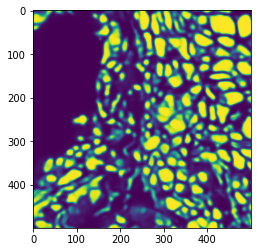

In [108]:
plt.imshow(pixelwise[0, :500, :500, 1])

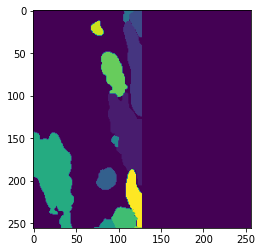

In [107]:
plt.imshow(y_train[3, :, :, 0])

In [92]:
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.morphology import watershed, remove_small_objects, h_maxima, disk, square, dilation
from skimage.segmentation import relabel_sequential
import scipy.ndimage as nd
from deepcell_toolbox.utils import erode_edges

def deep_watershed_mibi(model_output,
                        radius=10,
                        maxima_threshold=0.1,
                        interior_threshold=0.2,
                        small_objects_threshold=0,
                        interior_model='pixelwise-interior',
                        maxima_model='inner-distance',
                        interior_model_smooth=1,
                        maxima_model_smooth=0,
                        pixel_expansion=None):
    """Postprocessing function for multiplexed deep watershed models. Thresholds the inner
    distance prediction to find cell centroids, which are used to seed a marker
    based watershed of the pixelwise interior prediction.
    Args:
        model_output (dict): DeepWatershed model output. A dictionary containing key: value pairs
            with the transform name and the corresponding output. Currently supported keys:
            - inner_distance: Prediction for the inner distance transform.
            - outer_distance: Prediction for the outer distance transform.
            - fgbg: Foreground prediction for the foregound/background transform.
            - pixelwise_interior: Interior prediction for the interior/border/background transform.
        radius (int): Radius of disk used to search for maxima
        maxima_threshold (float): Threshold for the maxima prediction.
        interior_threshold (float): Threshold for the interior prediction.
        small_objects_threshold (int): Removes objects smaller than this size.
        fill_holes_threshold (int): maximum size for holes within segmented objects to be filled
        interior_model: semantic head to use to predict interior of each object
        maxima_model: semantic head to use to predict maxima of each object
        interior_model_smooth: smoothing factor to apply to interior model predictions
        maxima_model_smooth: smoothing factor to apply to maxima model predictions
        pixel_expansion: optional number of pixels to expand segmentation labels
    Returns:
        numpy.array: Uniquely labeled mask.
    Raises:
        ValueError: if interior_model or maxima_model names not in valid_model_names
        ValueError: if interior_model or maxima_model predictions do not have length 4
    """

    interior_model, maxima_model = interior_model.lower(), maxima_model.lower()

    valid_model_names = {'inner-distance', 'outer-distance', 'fgbg-fg', 'pixelwise-interior'}

    for name, model in zip(['interior_model', 'maxima_model'], [interior_model, maxima_model]):
        if model not in valid_model_names:
            raise ValueError('{} must be one of {}, got {}'.format(
                name, valid_model_names, model))

    interior_predictions = model_output[interior_model]
    maxima_predictions = model_output[maxima_model]

    zipped = zip(['interior_prediction', 'maxima_prediction'],
                 (interior_predictions, maxima_predictions))
    for name, arr in zipped:
        if len(arr.shape) != 4:
            raise ValueError('Model output must be of length 4. The {} model '
                             'provided was of shape {}'.format(name, arr.shape))

    label_images = []
    for batch in range(interior_predictions.shape[0]):
        interior_batch = interior_predictions[batch, ..., 0]
        interior_batch = nd.gaussian_filter(interior_batch, interior_model_smooth)

        if pixel_expansion is not None:
            interior_batch = dilation(interior_batch, selem=square(pixel_expansion * 2 + 1))

        maxima_batch = maxima_predictions[batch, ..., 0]
        maxima_batch = nd.gaussian_filter(maxima_batch, maxima_model_smooth)

        markers = h_maxima(image=maxima_batch,
                           h=maxima_threshold,
                           selem=disk(radius))

        markers = label(markers)

        label_image = watershed(-interior_batch,
                                markers,
                                mask=interior_batch > interior_threshold,
                                watershed_line=0)

        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)

        # fill in holes that lie completely within a segmentation label

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        label_images.append(label_image)

    label_images = np.stack(label_images, axis=0)
    label_images = np.expand_dims(label_images, axis=-1)

    return label_images